In [372]:
import pandas as pd
from statsmodels.regression.rolling import RollingOLS
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant 
import numpy as np

In [373]:
df = pd.read_excel('data.xlsx',sheet_name='X',index_col=0)

In [374]:
df.index = df.index.to_period("M")

In [405]:
df['RUBOIL'] = df.USDRUB * df.Urals
df['Sugar'] = df.Sugar * df.USDRUB
df['Cereal'] = df.Cereal * df.USDRUB

In [406]:
dfyy = df.drop(['Pi'],axis=1).pct_change(periods=12)
dfyy.tail()

,USDRUB,M2,Urals,Cereal,Sugar,RUBOIL
2020-08,0.126194,0.162031,-0.244767,0.208059,0.198064,-0.149461
2020-09,0.164233,0.160713,-0.333551,0.322663,0.250534,-0.224098
2020-10,0.205657,0.161997,-0.315306,0.405832,0.313225,-0.174494
2020-11,0.206185,0.140812,-0.324290,0.446911,0.333184,-0.184969
2020-12,0.176700,0.086378,-0.341836,0.400054,0.233604,-0.194409


In [407]:
dfyy['M2'] = dfyy.M2.shift(periods=7)
dfyy['Sugar'] = dfyy.Sugar.shift(periods=3)
dfyy['Cereal'] = dfyy.Cereal.shift(periods=8)
dfyy['RUBOIL'] = dfyy.RUBOIL.shift(periods=7)

In [408]:
dfyy.dropna(inplace=True,how='any')

In [409]:
dfyy.drop(['USDRUB','Urals'],inplace=True,axis=1)

In [410]:
date_start = '2017-01'

X = add_constant(dfyy[date_start:], prepend=False)
Y = df[['Pi']][date_start:]

In [464]:
mod = RollingOLS(Y, X,min_nobs=12
                # ,window = 24
                 ,expanding=True
                )

In [465]:
X.head()

,M2,Cereal,Sugar,RUBOIL,const
2017-01,0.122763,0.235263,0.587311,-0.087013,1.0
2017-02,0.123445,0.166579,0.376315,-0.122084,1.0
2017-03,0.117691,0.029795,0.127448,-0.039531,1.0
2017-04,0.127800,-0.032331,0.137978,-0.081586,1.0
2017-05,0.120954,-0.077557,0.163573,0.017634,1.0


In [466]:
rolling_params = mod.fit()

<AxesSubplot:>

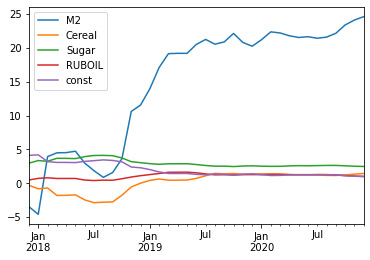

In [467]:
rolling_params.params.dropna().plot()

In [459]:
Y_HAT = Y*0

In [469]:
for x in X[12:-1].index:
    mo = OLS(Y[:x],X[:x])
    res = mo.fit()
    next_mo = x + pd.offsets.MonthEnd(1)
    Y_HAT.Pi[next_mo]  = res.predict(X[next_mo:next_mo]).values[0]

<AxesSubplot:>

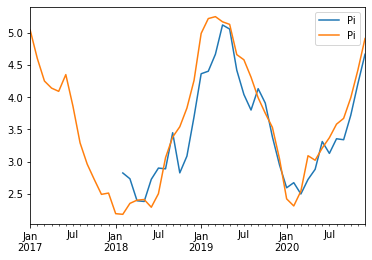

In [470]:
p1 = Y_HAT['2018-02':].plot()
Y.plot(ax=p1)

In [471]:
np.sqrt(((Y_HAT.Pi - Y.Pi)['2018-02':]).pow(2).mean())

0.383670270905566

In [473]:
mo = OLS(Y,X)
res = mo.fit()
Y_HAT_IN  = res.predict(X)

In [474]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     Pi   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     90.32
Date:                Tue, 12 Jan 2021   Prob (F-statistic):           2.41e-20
Time:                        23:00:37   Log-Likelihood:                -11.818
No. Observations:                  48   AIC:                             33.64
Df Residuals:                      43   BIC:                             42.99
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
M2            24.6163      3.065      8.032      0.0

<AxesSubplot:>

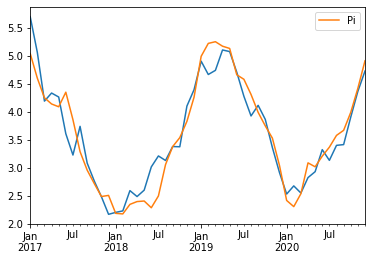

In [454]:
p1 = Y_HAT_IN.plot(); 
Y.plot(ax=p1)